# Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



## Load dataset:

In [2]:
max_images_per_cathegory = 20000

dataset_dir="datasets"
dataset_files = os.listdir(dataset_dir)
# Count number of drawing
count = 0
for file in dataset_files:
    data  = np.load(os.path.join(dataset_dir,file))
    data  = data[:max_images_per_cathegory]
    count += data.shape[0]

print(count,"images in total")

200000 images in total


['axe', 'cloud', 'dragon', 'eye', 'guitar', 'hand', 'piano', 'table', 'television', 'The Eiffel Tower']


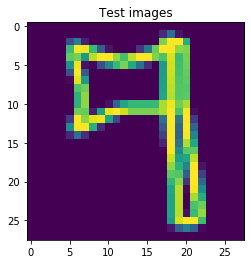

In [3]:
images          = np.zeros((count,784))
targets         = np.zeros(count)
target_names    = []

i=0;j=0
for file in dataset_files:
    d = np.load(os.path.join(dataset_dir,file))
    d = d[:max_images_per_cathegory]
    images[i:i+d.shape[0]]  = d
    targets[i:i+d.shape[0]] = j
    i+=d.shape[0]
    j+1
    target_names.append(file.split("full_numpy_bitmap_")[1].split(".npy")[0])

print(target_names)
plt.imshow(images[0].reshape(28,28))
plt.title("Test images")
plt.show()

## Normalisation

In [4]:
scalar = StandardScaler()
images = scalar.fit_transform(images.reshape(-1,28*28))
images = images.reshape(-1,28,28,1)
images = images.astype(np.float32)

## Split into two datasets

In [5]:
(train_images,test_images,train_targets,test_targets) = train_test_split(images,targets,test_size=0.33)

## Convert data to tensor

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_targets))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_images,test_targets))

# Training

In [15]:
class QuickDrawRecognitionModel(tf.keras.Model):
    
    def __init__(self):
        super(QuickDrawRecognitionModel, self).__init__()
        
        #Convolutionnal layes:
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation="relu", name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", name="conv3")
        
        #Flatten layer:
        self.flatten_layer = tf.keras.layers.Flatten(name="flatten")
        
        #Dense & output:
        self.d1 = tf.keras.layers.Dense(128,activation="relu",name="d1")
        self.out = tf.keras.layers.Dense(10,activation="softmax",name="output")
        
    def call(self,x):
        x = self.conv1(x)
        print(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten_layer(x)
        x = self.out(x)
        return x

In [16]:
loss_object     = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_object = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer       = tf.keras.optimizers.Adam()

#Accumulateurs:
train_loss_history     = tf.keras.metrics.Mean()
train_accuracy_history = tf.keras.metrics.Mean()

test_loss_history     = tf.keras.metrics.Mean()
test_accuracy_history = tf.keras.metrics.Mean()

model = QuickDrawRecognitionModel()

In [17]:
@tf.function
def train_step(images,targets):
    with tf.GradientTape() as tape:
        print("Before")
        predictions = model(images)
        print("After")
        loss = loss_object(targets,predictions)
        
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    
    accuracy = accuracy_object(targets,predictions)
    
    train_loss_history(loss)
    train_accuracy_history(accuracy)

In [18]:
@tf.function
def test_step(images,targets):
    predictions = model(images)
    loss = loss_object(targets,predictions)
    accuracy = accuracy_object(targets,predictions)
    
    test_loss_history(loss)
    test_accuracy_history(accuracy)

In [19]:
epoch = 100
batch_size = 500

history={"train":{"accuracy":[],"loss":[]},"test":{"accuracy":[],"loss":[]}}

for epoch in range(0,1):
    for images,targets in train_dataset.batch(batch_size):
        train_step(images,targets)
    
    for images,targets in test_dataset.batch(batch_size):
        test_step(images,targets)
    print("Epoch",epoch,"loss",train_loss_history.result())


Before
Tensor("quick_draw_recognition_model_1/conv1/Relu:0", shape=(500, 25, 25, 32), dtype=float32)
After
Before
Tensor("quick_draw_recognition_model_1/conv1/Relu:0", shape=(500, 25, 25, 32), dtype=float32)
After


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node quick_draw_recognition_model_1/conv1/Conv2D}}]]
	 [[GroupCrossDeviceControlEdges_0/Adam/Const/_23]] [Op:__inference_train_step_2956]